In [127]:
import requests as rq
import pandas as pd
import matplotlib.pyplot as plt
import json

HEADERS = {"X-API-Key":"b6c157d4681b4243894630269e9f9700"}

# makes dataframes nicer to read
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


personalMembershipID = 4611686018434543311
personalWarlockID = 2305843009292406567
gamesCount = 17
iterationsMax = 3
startingPGCR = 10689963777
pgcrInstanceList = []
# totalPlayerCount = 0 #used to get kills per capita among the games analyzed
p = {"accountId":[personalMembershipID], "characterId":[personalWarlockID]}
playerDF = pd.DataFrame(data=p)
weaponDF = pd.DataFrame(columns=["date"])
currentDate = ""
count = 0
# print(playerDF)
# accountID = personalMembershipID
# characterID = personalWarlockID
mode = 10 #control https://bungie-net.github.io/multi/schema_Destiny-HistoricalStats-Definitions-DestinyActivityModeType.html#schema_Destiny-HistoricalStats-Definitions-DestinyActivityModeType
# print(None)


def getPlayerMatches(accountID): #get a list of "gamesCount" games that the player has played. Going to be slapped into a DF later
    charID = getCharacterID(accountID=accountID)
    query = "https://www.bungie.net/Platform/Destiny2/-1/Account/" + str(accountID) + "/Character/" + str(charID) + "/Stats/Activities/?count=" + str(gamesCount) + "&mode=" + str(mode) + "&page=0"
    history = rq.get(query, headers=HEADERS)
    historyDF = pd.DataFrame.from_dict(history.json()["Response"]["activities"], orient="columns")
    return historyDF

def getPlayerMatches2(accountID, characterID):
    # charID = getCharacterID(accountID=accountID)
    query = "https://www.bungie.net/Platform/Destiny2/-1/Account/" + str(accountID) + "/Character/" + str(characterID) + "/Stats/Activities/?count=" + str(gamesCount) + "&mode=" + str(mode) + "&page=0"
    history = rq.get(query, headers=HEADERS)
    historyDF = pd.DataFrame.from_dict(history.json()["Response"]["activities"], orient="columns")
    return historyDF

def getPlayerAccounts(initialPGCR, iterator):
    global playerDF
    global weaponDF
    global currentDate
    global count
    # print(weaponDF)
    # print("**************************************************************")
    playerList = []
    # iterator += 1
    skip = False
    pgcr = rq.get("https://www.bungie.net/Platform/Destiny2/Stats/PostGameCarnageReport/" + str(initialPGCR), headers=HEADERS)
    pgcrDF = pd.DataFrame.from_dict(pgcr.json()["Response"], orient="index").T
    pgcrDF = pgcrDF[["period","entries"]]
    currentDate = str(pgcrDF.iat[0,0])[:10]
    # print("================================================================================================================================")
    # print(currentDate)
    # print(currentDate)
    if len(pgcrDF["entries"][0]) <= 12:
        for i in range(len(pgcrDF["entries"][0])):
            # print(initialPGCR)
            try:
                # print("entered statement")
                if initialPGCR in pgcrInstanceList:
                    continue
                for u in range(len(pgcrDF["entries"][0][i]["extended"]["weapons"])):
                    # print("loop tick")
                    count += 1
                    weaponId = pgcrDF["entries"][0][i]["extended"]["weapons"][u]["referenceId"]
                    weaponKills = pgcrDF["entries"][0][i]["extended"]["weapons"][u]["values"]["uniqueWeaponKills"]["basic"]["value"]
                    # append = pd.DataFrame({"date":[currentDate], "weaponId":[weaponId], "kills":[weaponKills]})
                    # print(weaponId, end=" | ")
                    # print(weaponKills)
                    # append = pd.DataFrame({str(weaponId):[weaponKills]})
                    # print(append)
                    # print("\n\n\n")
                    # # print("right above concat")
                    # weaponDF = pd.concat([weaponDF, append], axis=1)
                    # print(weaponDF)
                    # print("\n\n\n")
                    # itemName = rq.get("https://www.bungie.net/Platform/Destiny2/Manifest/DestinyInventoryItemDefinition/"+str(weaponId), headers=HEADERS).json()["Response"]["displayProperties"]["name"]
                    append2 = pd.DataFrame({"date":[currentDate], str(weaponId):[weaponKills]})
                    # print(append2)
                    # print("\n\n\n")
                    weaponDF = pd.concat([weaponDF, append2], ignore_index=True)
                    # print(weaponDF)
                    # print("========================================================================================")
                    # weaponDF = pd.concat([weaponDF, append], axis=1, ignore_index=True)
            except:
                pass
            accountId = pgcrDF["entries"][0][i]["player"]["destinyUserInfo"]["membershipId"]
            playerList.append(accountId)
            char = getCharacterID(accountID=accountId)
            info = {"accountId":[accountId], "characterId":[char]}
            df = pd.DataFrame(data=info)
            playerDF = pd.concat([playerDF, df], ignore_index=True)
        pgcrInstanceList.append(initialPGCR)
        # print("================================================================================================================================")
        # print(weaponDF)
        # print("================================================================================================================================")
        for j in range(len(playerList)):
            iterPlayer = playerList[j]
            iterQuery = rq.get("https://www.bungie.net/Platform/Destiny2/-1/Account/" + str(iterPlayer) + "/Character/" + str(getCharacterID(iterPlayer)) + "/Stats/Activities/?count=" + str(1) + "&mode=" + str(mode) + "&page=0", headers=HEADERS)
            # print(iterQuery.json())
            if(iterQuery.json()["ErrorCode"] == 1):
                if len(iterQuery.json()["Response"]) > 0:
                    if len(iterQuery.json()["Response"]["activities"]) > 0:
                        iterInstance = iterQuery.json()["Response"]["activities"][0]["activityDetails"]["instanceId"]
                        if ((iterator < iterationsMax) and not(skip)):
                            getPlayerAccounts(iterInstance, iterator=iterator+1)
            #     skip = False
            # else:
            #     skip = True
            # print((iterInstance))
            
        



def getCharacterID(accountID): #gets the character that the account has the most time on
    query = ""
    for i in range(5):
        query = "https://www.bungie.net/Platform/Destiny2/" + str(i+1) + "/Profile/" + str(accountID) + "/?components=Profiles,Characters"
        request = rq.get(query, headers=HEADERS)
        # print(request.json()["ErrorCode"])
        if(request.json()["ErrorCode"] == 1):
            ids = request.json()["Response"]["profile"]["data"]["characterIds"]
            # print(ids)
            maxTime = 0
            maxTimeID = 0
            for id in ids:
                if int(request.json()["Response"]["characters"]["data"][str(id)]["minutesPlayedTotal"]) > int(maxTime):
                    maxTime = request.json()["Response"]["characters"]["data"][str(id)]["minutesPlayedTotal"]
                    maxTimeID = id
            return maxTimeID

manifest = rq.get("https://www.bungie.net/Platform/Destiny2/Manifest", headers=HEADERS)
# print(manifest.json())

getPlayerAccounts(startingPGCR, 0)
# weaponDF.dropna(subset=["date"], inplace=True)
# weaponDF["date"] = str(weaponDF["date"])[0:10]
# print(weaponDF)

weaponDF.fillna(0, inplace=True)

# can call

# for col in weaponDF:
#     hashInfo = rq.get("https://www.bungie.net/Platform/Destiny2/Manifest/DestinyInventoryItemDefinition/"+str(col), headers=HEADERS)
#     itemName = hashInfo.json()["Response"]["displayProperties"]["name"]
#     #check for other fields to pull, namely exotic and weapon type
#     weaponNamesDF = weaponDF.rename(columns={str(col):itemName})

# weaponNamesDFKills = weaponNamesDF.groupby(["date"]).sum()
# weaponNamesDFCount = weaponNamesDF.groupby(["date"]).count()
# print(playerDF)

In [140]:
# #processing done after getting the list, meaning that we dont have to wait for the long runtime to get other information
import numpy as np
weaponNamesDF = weaponDF
for col in weaponNamesDF:
    # print(col)
    if col != "date":
        hashInfo = rq.get("https://www.bungie.net/Platform/Destiny2/Manifest/DestinyInventoryItemDefinition/"+str(col), headers=HEADERS)
        # print(hashInfo.json())
        itemName = hashInfo.json()["Response"]["displayProperties"]["name"]
        #check for other fields to pull, namely exotic and weapon type
        weaponNamesDF = weaponNamesDF.rename(columns={str(col):itemName})

In [ ]:
weaponNamesDFKills = weaponNamesDF.groupby(["date"]).sum()
weaponNamesDFCount = weaponNamesDF.groupby(["date"]).count()
weaponNamesDFKills30 = weaponNamesDFKills

for col in weaponNamesDFKills30:
    weaponNamesDFKills30 = weaponNamesDFKills30[weaponNamesDFKills30[col] > 30]  

[]

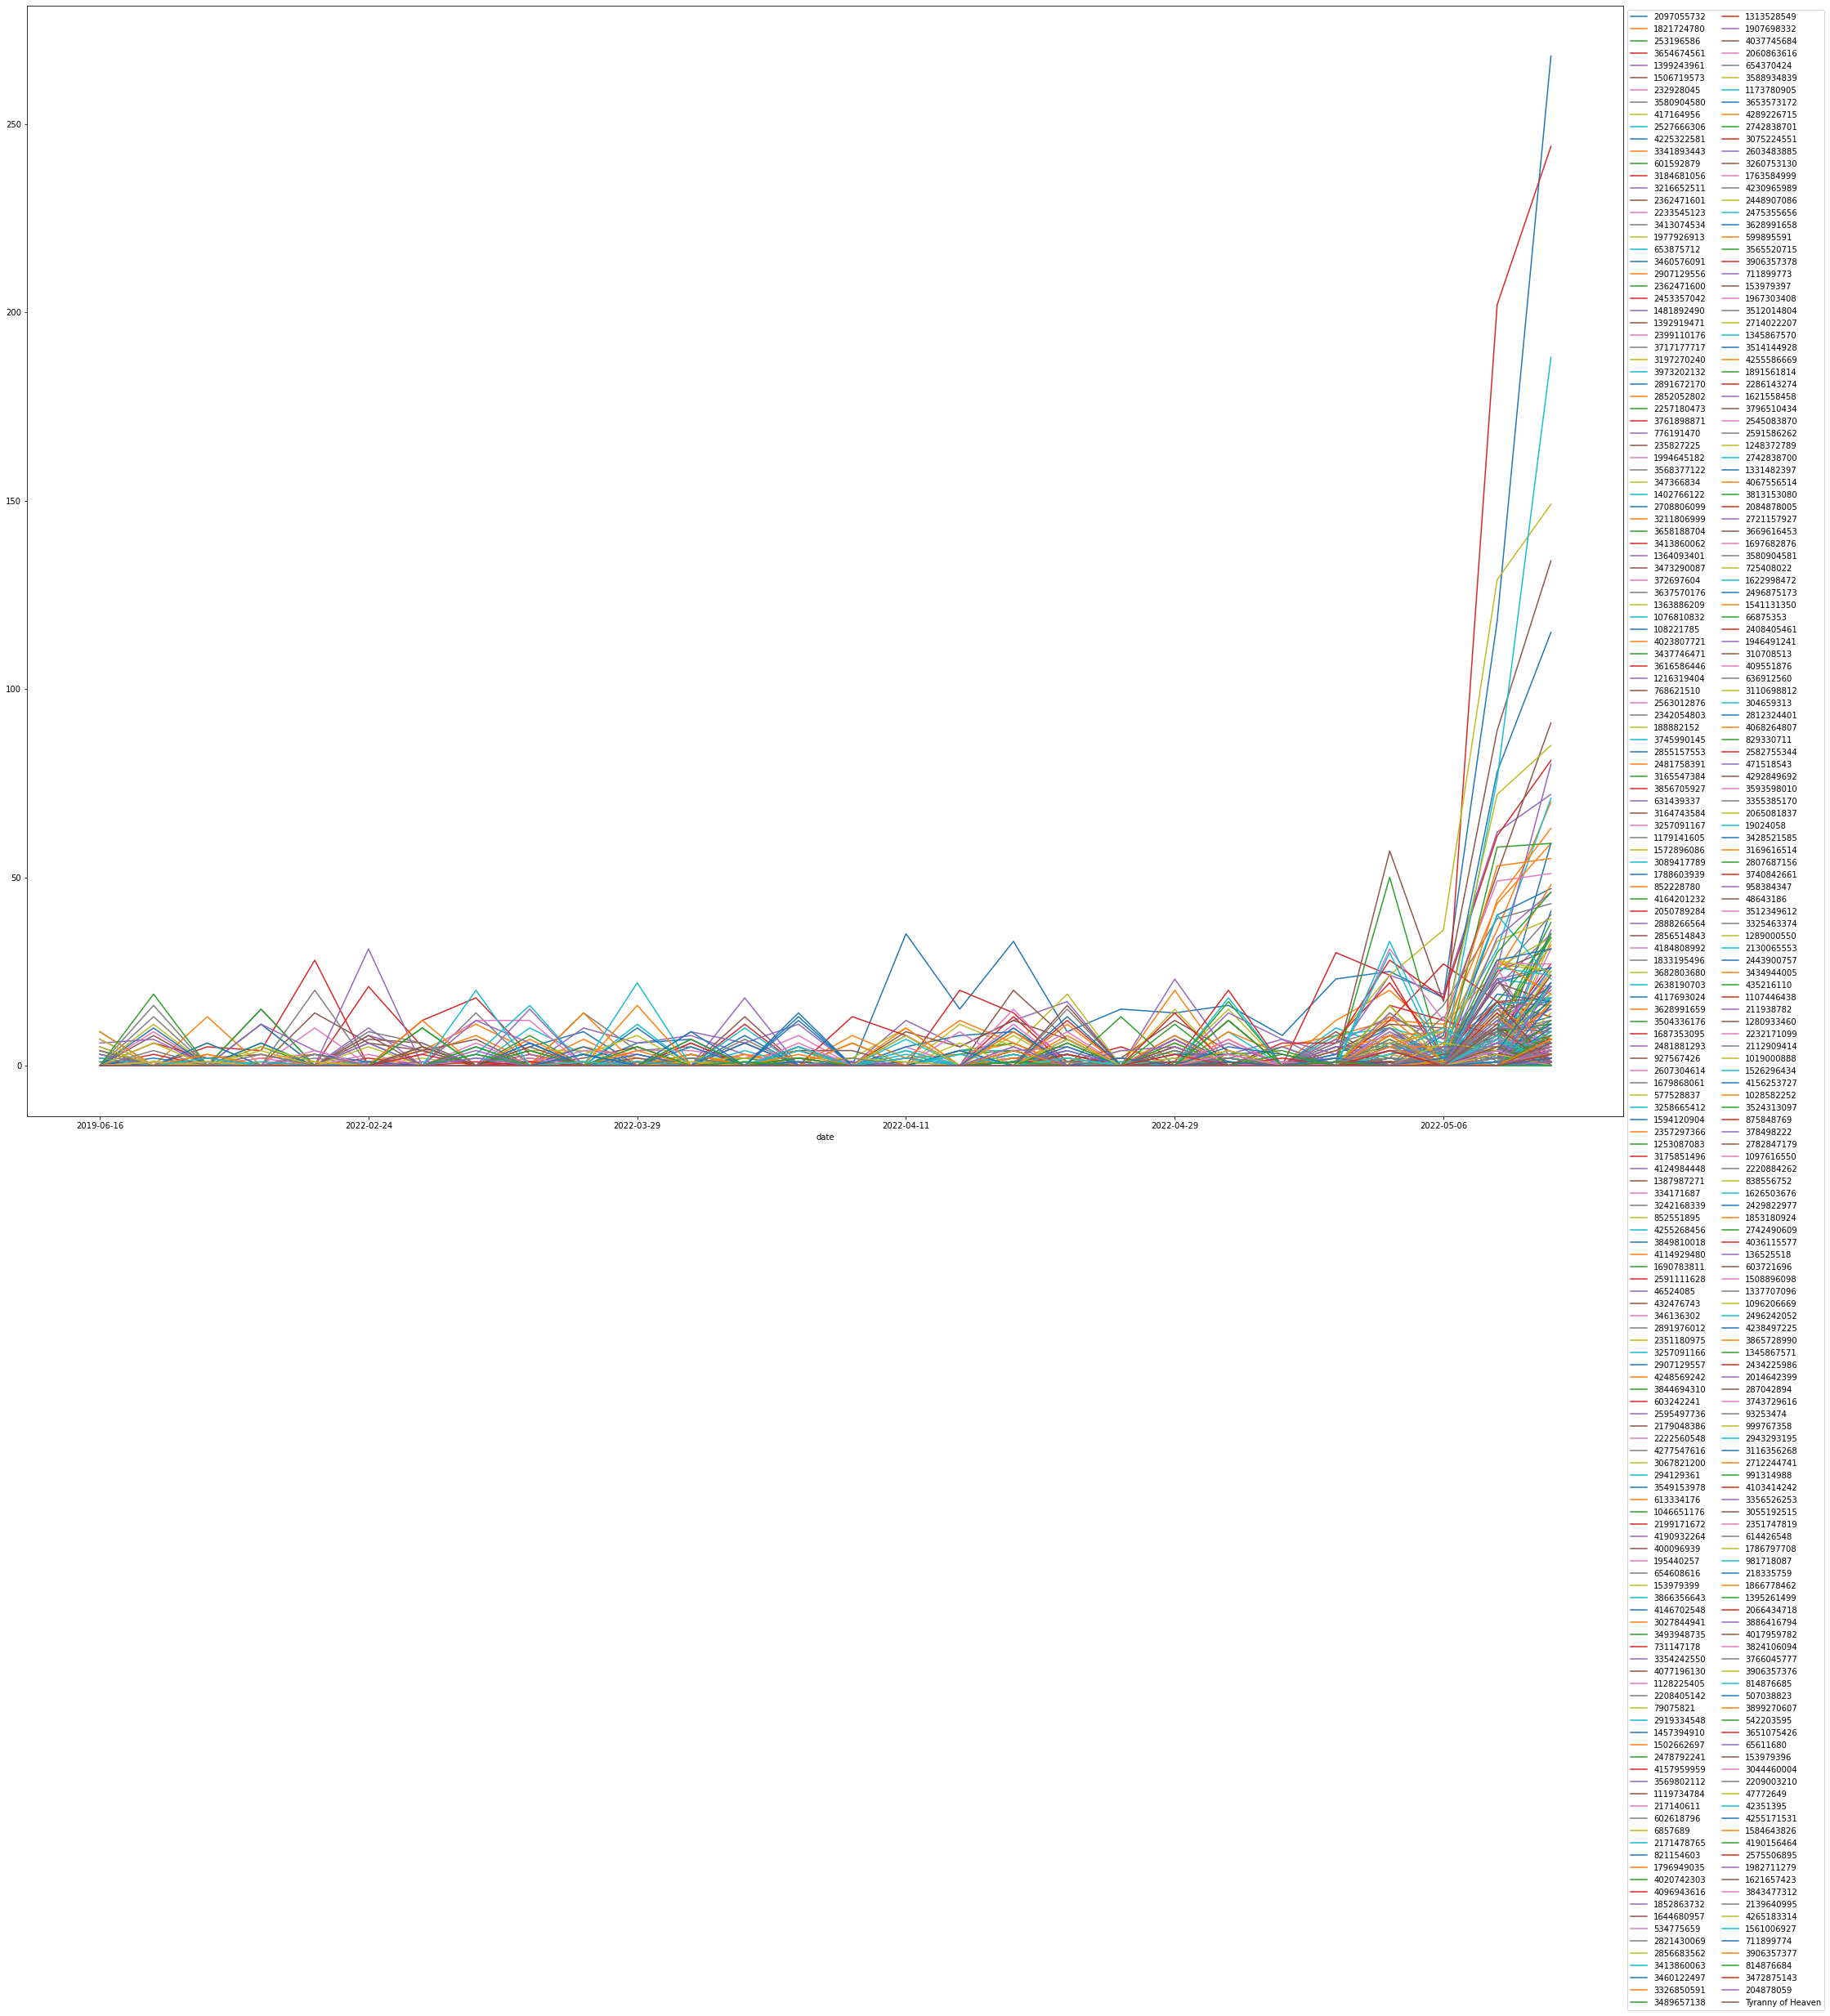

In [ ]:
# print(weaponDF)
# ax = weaponDF.plot.line(x="date", figsize=(35,25))
ax = weaponNamesDFKills30.plot.line(figsize=(35,25))
ax.legend(bbox_to_anchor=(1.0, 1.0), ncol=3)
ax.plot()